In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")




Using device: cuda


In [ ]:
# DATA_DIR = '/content/drive/MyDrive/data/Chameleon'
DATA_DIR = '../DL_project/Chameleon'

# TRAIN_DIR = '../DL_project/train'
# TEST_DIR = '../DL_project/test'
# VAL_DIR = '../DL_project/validation'

In [ ]:
##resizing images for training so they can fit into batches
# (testing robustness with different size later)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Standard size for training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

try:

    full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

    # Classes found
    print(f"Classes found: {full_dataset.classes}")

    # Split into Train/Val (80% Train, 20% Val)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    print(f"Data Loaded Successfully!")
    print(f"Training images: {len(train_dataset)}")
    print(f"Validation images: {len(val_dataset)}")

except Exception as e:
    print("ERROR Loading Data:", e)


Classes found: ['fake', 'real']
✅ Data Loaded Successfully!
Training images: 20826
Validation images: 5207


In [ ]:
## Defining the Model

## -----MOdel A: EfficientNet with GAP ------

model_gap = models.efficientnet_b0(weights='DEFAULT')

## Freezing features

for param in model_gap.features.parameters():
    param.requires_grad = False

# GAP layer
num_ftrs = model_gap.classifier[1].in_features
model_gap.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, 2)
)
model_gap = model_gap.to(device)



# --- Model B:Without GAP ---
model_flatten = models.efficientnet_b0(weights='DEFAULT')

# Freeze features
for param in model_flatten.features.parameters():
    param.requires_grad = False

# Removing GAP, add Flatten
model_flatten.avgpool = nn.Identity()

flattened_size = 1280 * 7 * 7

model_flatten.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(flattened_size, 2)
)
model_flatten = model_flatten.to(device)

print("Models Built: 'model_gap' and 'model_flatten'")



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/pranaya/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 81.9MB/s]


Models Built: 'model_gap' and 'model_flatten'


In [ ]:
def train_model(model, loader, name, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    print(f"\n--- Training {name} ---")
   

    for epoch in range(epochs):
        model.train()

        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

         # Calculating average for each epoch
        epoch_loss = running_loss / len(loader)
        epoch_acc = 100. * correct / total

        print(f"Epoch {epoch+1}: Loss {epoch_loss:.4f} Acc {epoch_acc:.2f}%")

    ## Training both models!
train_model(model_gap, train_loader, "Model A (GAP)", epochs=10)
train_model(model_flatten, train_loader, "Model B (Flatten)", epochs=10)






--- Training Model A (GAP) ---
Epoch 1: Loss 0.2922 Acc 88.03%
Epoch 2: Loss 0.2852 Acc 88.57%
Epoch 3: Loss 0.2834 Acc 88.33%
Epoch 4: Loss 0.2796 Acc 88.54%
Epoch 5: Loss 0.2838 Acc 88.41%
Epoch 6: Loss 0.2809 Acc 88.60%
Epoch 7: Loss 0.2788 Acc 88.78%
Epoch 8: Loss 0.2871 Acc 87.98%
Epoch 9: Loss 0.2803 Acc 88.57%
Epoch 10: Loss 0.2819 Acc 88.43%

--- Training Model B (Flatten) ---
Epoch 1: Loss 0.3177 Acc 87.11%
Epoch 2: Loss 0.1875 Acc 92.78%
Epoch 3: Loss 0.1560 Acc 94.00%
Epoch 4: Loss 0.1241 Acc 95.23%
Epoch 5: Loss 0.1159 Acc 95.59%
Epoch 6: Loss 0.1091 Acc 96.03%
Epoch 7: Loss 0.1007 Acc 96.14%
Epoch 8: Loss 0.0866 Acc 96.77%
Epoch 9: Loss 0.0819 Acc 97.01%
Epoch 10: Loss 0.0906 Acc 96.58%


In [27]:
print("------Running Robustness Test------\n")

sample_image, label = val_dataset[0]

## Resizing to not standard dimensions
resize_transform = transforms.Resize((300,300))
large_image = resize_transform(sample_image).unsqueeze(0).to(device)
print(f"Testing with image size: {large_image.shape}\n")

## GAP model
print("------Testing GAP model------")

try:
    model_gap.eval()
    output = model_gap(large_image)
    print("GAP model successfully handled the large image\n")
except Exception as e:
    print(f"failed:{e}")

## TEsting flatten model
print("------Testing Flatten model------\n")
try:
    model_flatten.eval()
    output = model_flatten(large_image)
    print("Flatten model successfully handled the large image")
except Exception as e:
    print("Error: shape mismatch")
    print("Flatten model cannot handle real-world size variations")

    



------Running Robustness Test------

Testing with image size: torch.Size([1, 3, 300, 300])

------Testing GAP model------
GAP model successfully handled the large image

------Testing Flatten model------

Error: shape mismatch
Flatten model cannot handle real-world size variations


In [35]:
def predict_image(model, image_tensor, label, class_names):
    model.eval()
    input_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        probabilities = F.softmax(logits, dim=1)

    conf, predicted_class = torch.max(probabilities, 1)
    predicted_label = class_names[predicted_class.item()]
    actual_label = class_names[label]
    confidence_score = conf.item() * 100

    ### Visualizing the prediction
    image_display = image_tensor.cpu().squeeze().permute(1,2,0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_display = std * image_display + mean
    image_display = np.clip(image_display, 0, 1)
    
    plt.figure(figsize=(5,5))
    plt.imshow(image_display)
    plt.axis('off')
    # print(f"The actual label is {actual_label}")
    # print(f"The predicted label is {predicted_label}")

    title_color = 'green' if predicted_label == actual_label else 'red'
    plt.title(f"Actual label: {actual_label}\nPredicted label: {predicted_label} (Conf: {confidence_score:.2f}%)", color=title_color)
    plt.show()



    

        

------Predicting Random Image------


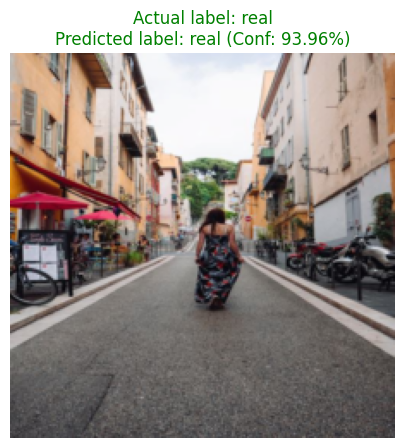

In [40]:
import random

## Selecting a random image from the validation set
random_index = random.randint(0, len(val_dataset)-1)
sample_image, sample_label = val_dataset[random_index]


class_names = full_dataset.classes

print("------Predicting Random Image------")

predict_image(model_gap, sample_image,sample_label, class_names)
    

